In [1]:
import json
from collections import Counter, defaultdict

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [3]:
plt.rcParams["font.size"] = 14

In [4]:
TRAIN_PATH = "/Users/m-suzuki/data/qanta/2018/qanta.train.2018.04.18.json"
DEV_PATH = "/Users/m-suzuki/data/qanta/2018/qanta.dev.2018.04.18.json"
TEST_PATH = "/Users/m-suzuki/data/qanta/2018/qanta.test.2018.04.18.json"

In [5]:
with open(TRAIN_PATH) as f:
    train = pd.DataFrame.from_dict(json.load(f)['questions'])

In [6]:
with open(DEV_PATH) as f:
    dev = pd.DataFrame.from_dict(json.load(f)['questions'])

In [7]:
train.head()

,text,answer,page,category,subcategory,tournament,difficulty,year,proto_id,qdb_id,dataset,qanta_id,tokenizations,first_sentence,gameplay,fold
0,After this character relates a story about how...,Queequeg,Queequeg,Literature,American,ACF Winter,College,2010,5476990eea23cca905506d51,NaN,protobowl,0,"[[0, 192], [193, 398], [399, 506], [507, 693],...",After this character relates a story about how...,True,buzztrain
1,The oldest document written in this language i...,Daco-Romanian [also accept limba română],Romanian_language,Social Science,Anthropology,ACF Winter,College,2010,5476990eea23cca905506d52,NaN,protobowl,1,"[[0, 184], [185, 305], [306, 426], [426, 786]]",The oldest document written in this language i...,True,guesstrain
2,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,protobowl,2,"[[0, 134], [135, 262], [263, 398], [399, 518],...",This state's largest city endured an 1855 Rum ...,True,guesstrain
3,"In one work, this man provides definitions for...",Charles Sanders Peirce,Charles_Sanders_Peirce,Social Science,Philosophy,ACF Winter,College,2010,5476990eea23cca905506d54,NaN,protobowl,3,"[[0, 127], [128, 251], [252, 343], [344, 525],...","In one work, this man provides definitions for...",True,guesstrain
4,One family in this work flees France after res...,"Frankenstein, or the Modern Prometheus",Frankenstein,Literature,European,ACF Winter,College,2010,5476990eea23cca905506d55,NaN,protobowl,4,"[[0, 168], [169, 351], [352, 587], [588, 673],...",One family in this work flees France after res...,True,guesstrain


In [8]:
train_counts = train['page'].value_counts()

In [9]:
train_counts

Japan                            99
Australia                        97
China                            97
Spain                            89
Brazil                           87
                                 ..
Țara                              1
Turin                             1
Shammai                           1
Pragmatic_Sanction_of_Bourges     1
Cherry                            1
Name: page, Length: 25969, dtype: int64

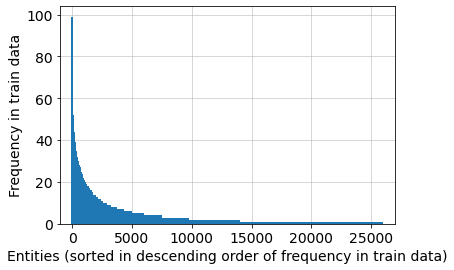

In [10]:
plt.figure()
ax = train_counts.plot.bar(width=100.0, rot=0)
ax.set_xticks(np.arange(0,len(train_counts),5000))
ax.set_xticklabels(np.arange(0,len(train_counts),5000))
ax.grid(which='major', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Entities (sorted in descending order of frequency in train data)')
ax.set_ylabel('Frequency in train data')
ax.set_xlim(-1000, len(train_counts)+1000)
plt.savefig('images/train_freq.pdf', bbox_inches='tight')

In [11]:
num_unanswerable = 0
with open(TEST_PATH) as f:
    questions = json.load(f)['questions']

print(len(questions))
    
for q in questions:
    entity = q['page']
    if entity not in train_counts or train_counts[entity] == 0:
        num_unanswerable += 1
    
print(num_unanswerable)
print(1 - num_unanswerable / len(questions))

4104
648
0.8421052631578947


In [12]:
XLNET_QUIZ_PREDICTION_PATH = 'work/quiz-ep10/xlnet-base/prediction_test.json'
XLNET_WIKI_QUIZ_PREDICTION_PATH = 'work/wiki-ep5_quiz-ep10/xlnet-base/prediction_test.json'

In [13]:
def make_accuracy_bins(fpath):
    freq_accuracy_bins = defaultdict(list)
    sid_accuracy_bins = defaultdict(list)
    
    with open(fpath) as f:
        for line in f:
            pred_data = json.loads(line)
            pred_answer = pred_data['top1_entity']
            correct_answer = pred_data['metadata']['entity']
            sid = pred_data['metadata'].get('sentence_id')
            
            accuracy = int(pred_answer == correct_answer)

            if correct_answer in train_counts:
                freq = train_counts[correct_answer]
            else:
                freq = 0
                
            freq_label = '6+' if freq >= 6 else str(freq)
            freq_accuracy_bins[freq_label].append(accuracy)
            
            if sid is not None:
                sid += 1  # 0-origin -> 1-origin
                sid_label = '7+' if sid >= 7 else str(sid)
                sid_accuracy_bins[sid_label].append(accuracy)
    
    freq_mean_accuracies = defaultdict(float)
    for label in ['0', '1', '2', '3', '4', '5', '6+']:
        if label in freq_accuracy_bins:
            accuracies = freq_accuracy_bins[label]
            assert len(accuracies) > 0
            mean_accuracy = sum(accuracies) / len(accuracies)
            freq_mean_accuracies[label] = mean_accuracy
    
    sid_mean_accuracies = defaultdict(float)
    for label in ['1', '2', '3', '4', '5', '6', '7+']:
        if label in sid_accuracy_bins:
            accuracies = sid_accuracy_bins[label]
            assert len(accuracies) > 0
            mean_accuracy = sum(accuracies) / len(accuracies)
            sid_mean_accuracies[label] = mean_accuracy
            
    return freq_mean_accuracies, sid_mean_accuracies

In [14]:
xlnet_quiz_freq_accuracies, _ = make_accuracy_bins(XLNET_QUIZ_PREDICTION_PATH)
xlnet_wiki_quiz_freq_accuracies, _ = make_accuracy_bins(XLNET_WIKI_QUIZ_PREDICTION_PATH)

In [15]:
freq_labels = ['1', '2', '3', '4', '5', '6+']
xlnet_freq_accuracies_dict = {
    'Qanta': [xlnet_quiz_freq_accuracies[label] for label in freq_labels],
    r'Wiki$\rightarrow$Qanta': [xlnet_wiki_quiz_freq_accuracies[label] for label in freq_labels]
}
xlnet_freq_accuracies_df = pd.DataFrame(data=xlnet_freq_accuracies_dict, index=freq_labels)

In [16]:
xlnet_freq_accuracies_df

,Qanta,Wiki$\rightarrow$Qanta
1,0.358127,0.487603
2,0.591912,0.650735
3,0.612150,0.700935
4,0.725275,0.785714
5,0.737589,0.815603
6+,0.865587,0.880473


<Figure size 432x288 with 0 Axes>

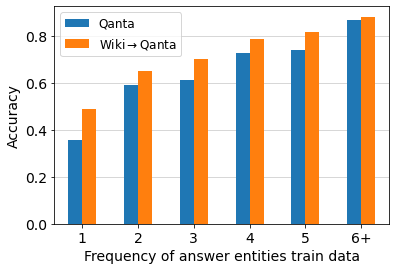

In [17]:
plt.figure()
ax = xlnet_freq_accuracies_df.plot.bar(rot=0)
ax.grid(which='major', axis='y', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Frequency of answer entities train data')
ax.set_ylabel('Accuracy')
ax.legend(fontsize=12)
plt.savefig('images/accuracy_freq.pdf', bbox_inches='tight')

In [18]:
XLNET_QUIZ_SPLIT_PREDICTION_PATH = 'work/quiz-ep10/xlnet-base/prediction_test_split.json'
XLNET_WIKI_QUIZ_SPLIT_PREDICTION_PATH = 'work/wiki-ep5_quiz-ep10/xlnet-base/prediction_test_split.json'

In [19]:
_, xlnet_quiz_split_sid_accuracies = make_accuracy_bins(XLNET_QUIZ_SPLIT_PREDICTION_PATH)
_, xlnet_wiki_quiz_split_sid_accuracies = make_accuracy_bins(XLNET_WIKI_QUIZ_SPLIT_PREDICTION_PATH)

In [20]:
sid_labels = ['1', '2', '3', '4', '5', '6', '7+']
xlnet_split_sid_accuracies_dict = {
    'Qanta': [xlnet_quiz_split_sid_accuracies[label] for label in sid_labels],
    r'Wiki$\rightarrow$Qanta': [xlnet_wiki_quiz_split_sid_accuracies[label] for label in sid_labels]
}
xlnet_split_sid_accuracies_df = pd.DataFrame(data=xlnet_split_sid_accuracies_dict, index=sid_labels)

In [21]:
xlnet_split_sid_accuracies_df

,Qanta,Wiki$\rightarrow$Qanta
1,0.126706,0.144006
2,0.194932,0.220273
3,0.267300,0.308723
4,0.362216,0.393215
5,0.446909,0.476820
6,0.500596,0.528623
7+,0.488292,0.519972


<Figure size 432x288 with 0 Axes>

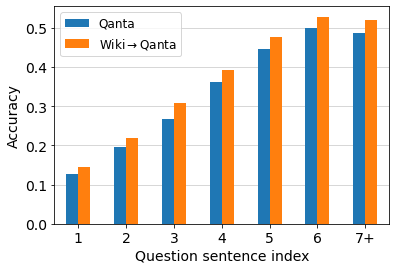

In [22]:
plt.figure()
ax = xlnet_split_sid_accuracies_df.plot.bar(rot=0)
ax.grid(which='major', axis='y', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Question sentence index')
ax.set_ylabel('Accuracy')
ax.legend(fontsize=12)
plt.savefig('images/accuracy_sid.pdf', bbox_inches='tight')